In [2]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB3

2022-01-14 12:50:25.697257: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
# create a data generator

datagen = ImageDataGenerator(validation_split=0.1)

# Image size determined by EfficientNetB0
IMG_SIZE = 320

# load and iterate training dataset
train_it = datagen.flow_from_directory(
    '../../master-data/train_large/rgb', 
    target_size=(IMG_SIZE, IMG_SIZE),
    subset="training", 
    class_mode="sparse",
    batch_size=32)

val_it = datagen.flow_from_directory(
    '../../master-data/train_large/rgb', 
    target_size=(IMG_SIZE, IMG_SIZE), 
    subset="validation", 
    class_mode="sparse",
    batch_size=32)

Found 81000 images belonging to 11 classes.
Found 9000 images belonging to 11 classes.


In [5]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

optimizer = Adam(learning_rate=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor= 0.5, min_lr= 1e-6, verbose=1)

# Open a strategy scope.
with strategy.scope():
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    n_classes = 11
    efinet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

    model = Sequential()
    model.add(efinet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on all available devices.
history = model.fit(train_it, epochs=20, verbose=1, validation_data=val_it, callbacks=[early_stop, rlrop], workers=10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2022-01-14 12:51:35.988905: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-14 12:51:35.991379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-14 12:51:36.156329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-14 12:51:36.158745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-14 12:51:36.161018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Tesl

Number of devices: 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

2022-01-14 12:51:48.993869: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_29839"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
. Consider eit

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1


2022-01-14 12:53:29.194581: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-14 12:53:31.178736: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-01-14 12:53:33.408350: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-01-14 12:53:33.597949: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


2532/2532 [==============================] - ETA: 0s - loss: 1.0023 - accuracy: 0.6789

2022-01-14 13:33:05.209650: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_186048"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
. Consider ei

2532/2532 [==============================] - 2527s 608ms/step - loss: 1.0021 - accuracy: 0.6789 - val_loss: 0.5791 - val_accuracy: 0.8281
Epoch 2/20
2532/2532 [==============================] - 616s 243ms/step - loss: 0.2086 - accuracy: 0.9332 - val_loss: 0.2601 - val_accuracy: 0.9220
Epoch 3/20
2532/2532 [==============================] - 620s 244ms/step - loss: 0.1278 - accuracy: 0.9586 - val_loss: 0.1795 - val_accuracy: 0.9434
Epoch 4/20
2532/2532 [==============================] - 619s 244ms/step - loss: 0.0837 - accuracy: 0.9732 - val_loss: 0.2093 - val_accuracy: 0.9370
Epoch 5/20
2532/2532 [==============================] - 613s 242ms/step - loss: 0.0639 - accuracy: 0.9793 - val_loss: 0.2695 - val_accuracy: 0.9240
Epoch 6/20
2532/2532 [==============================] - 612s 241ms/step - loss: 0.0496 - accuracy: 0.9843 - val_loss: 0.1514 - val_accuracy: 0.9582
Epoch 7/20
2532/2532 [==============================] - 613s 242ms/step - loss: 0.0406 - accuracy: 0.9877 - val_loss: 0.21

2022-01-14 16:07:29.282726: W tensorflow/core/framework/op_kernel.cc:1751] Invalid argument: TypeError: 'NoneType' object is not subscriptable
Traceback (most recent call last):

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 891, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 807, in wrapped_generator
    for data in generator_fn():

  File "/home/users/tdejesus/miniconda3/envs/efinet/lib/python3.7/site-

Epoch 17/20
2532/2532 [==============================] - 612s 241ms/step - loss: 0.0075 - accuracy: 0.9973 - val_loss: 0.2328 - val_accuracy: 0.9531
Epoch 18/20
2532/2532 [==============================] - 612s 241ms/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.3016 - val_accuracy: 0.9213
Epoch 19/20
2532/2532 [==============================] - 612s 241ms/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.2058 - val_accuracy: 0.9586
Epoch 20/20
2532/2532 [==============================] - 611s 241ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.1537 - val_accuracy: 0.9702

Epoch 00020: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


In [7]:
model.save_weights("efficientnetb3_large.h5")
model.save('./efficientnetb3_large', save_format='tf')

2022-01-14 16:48:34.042089: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./efficientnetb3_large/assets


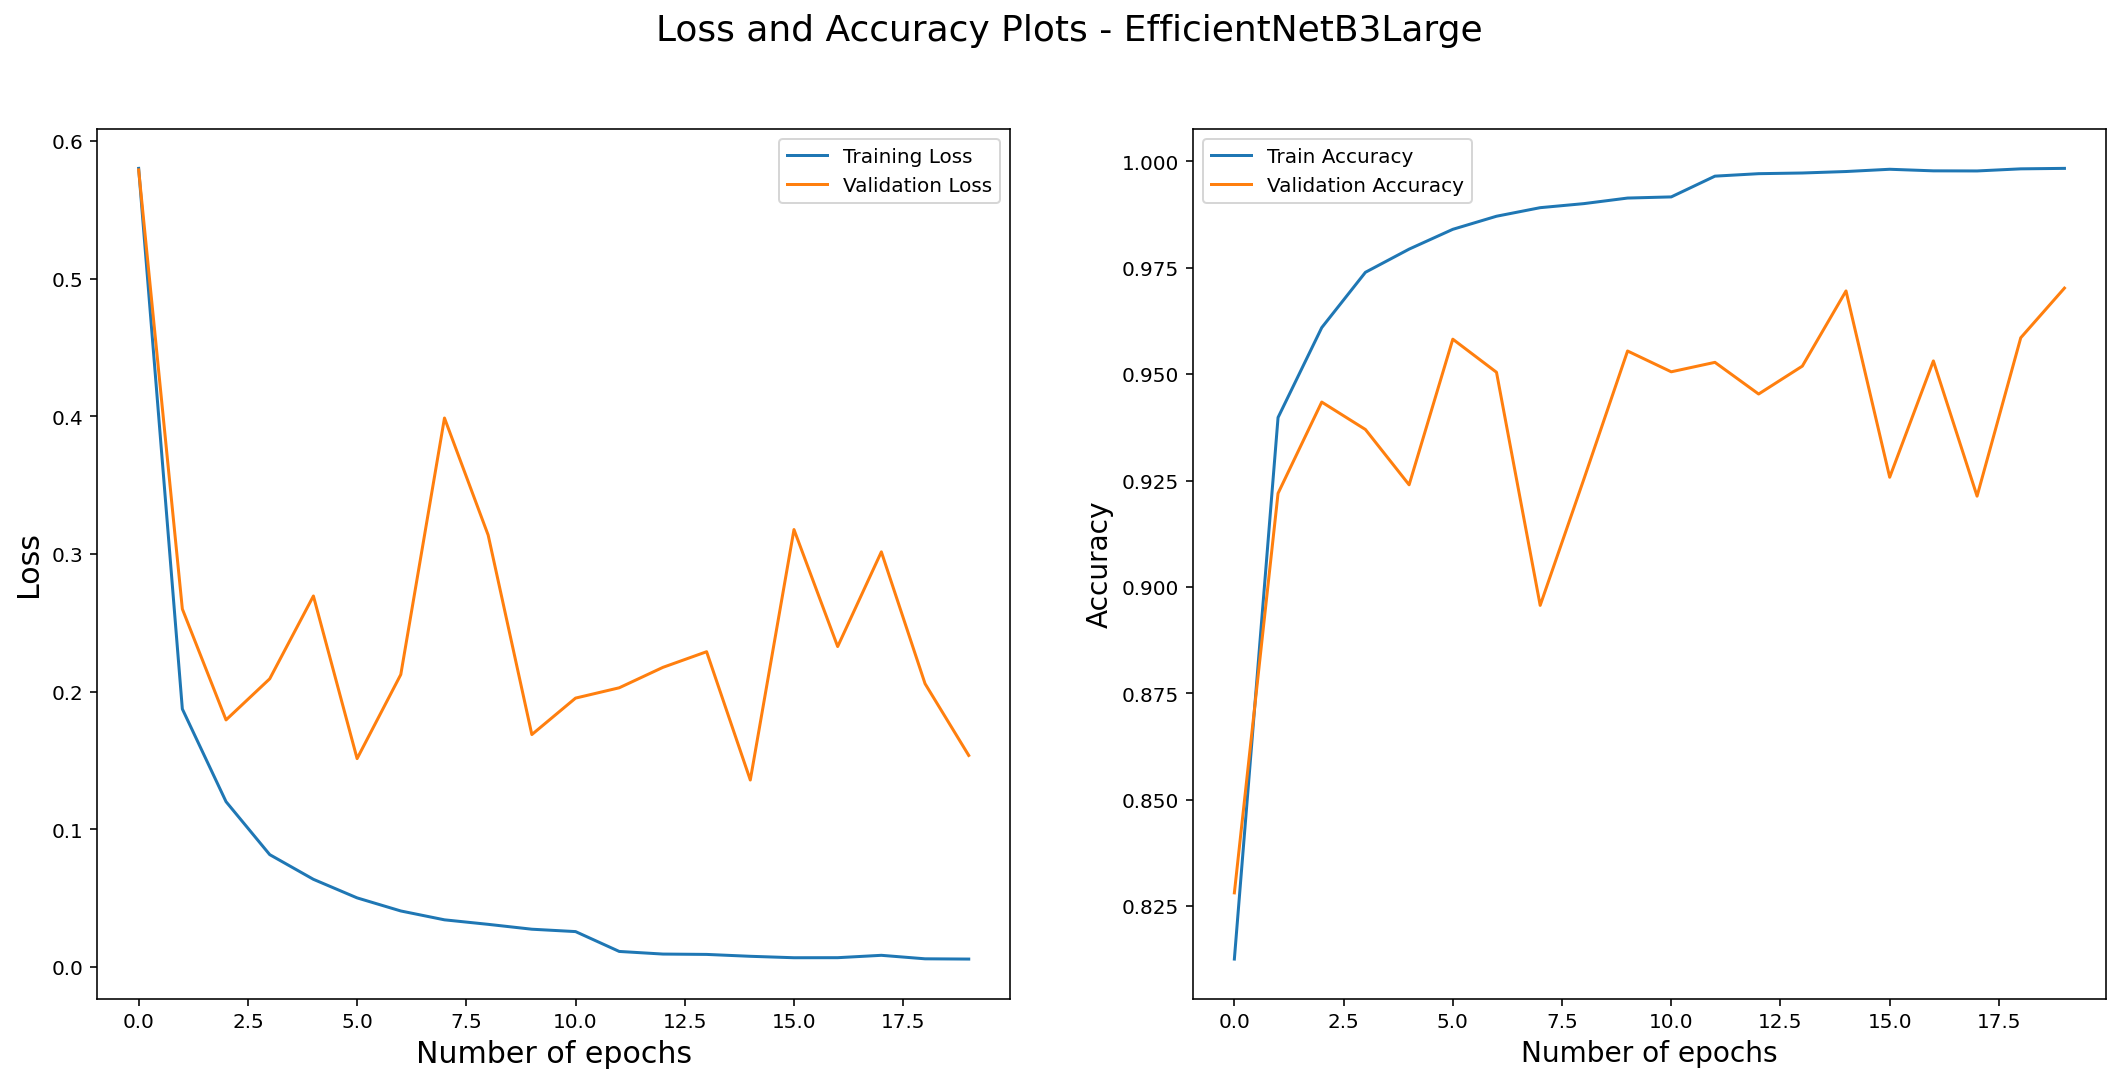

In [9]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots - EfficientNetB3Large', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.savefig('efficientnetb3_large.pdf')
plt.show()

In [10]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history-efficientnetb3_large.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)